In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import json

In [2]:
# obs_bayes2_m23m28 = pd.read_csv("obs_bayes2_m23m28.csv")
obs_bayes2_m15a01 = pd.read_csv("obs_bayes2_m15a01.csv")
# obs_bayes2_j01f28 = pd.read_csv("obs_bayes2_j01f28.csv")
# obs_bayes2_j01f28_v2 = pd.read_csv("obs_bayes2_j01f28_v2.csv")
# obs_bayes2_j01f28_v3 = pd.read_csv("obs_bayes2_j01f28_v3.csv")

all_obs = [
#     obs_bayes2_m23m28,
    obs_bayes2_m15a01,
#     obs_bayes2_j01f28,
#     obs_bayes2_j01f28_v2,
#     obs_bayes2_j01f28_v3,
]
all_labels = [
#     'bayes2_m23m28',
    'bayes2_m15a01',
#     'bayes2_j01f28',
#     'bayes2_j01f28_v2',
#     'bayes2_j01f28_v3',
]

def add_cols(df):
    if 'date' in df.columns and 'time' in df.columns:
        df['datetime'] = (df['date'] + ' ' + df['time']).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %I:%M %p'))
        df.drop(['date','time'], axis=1, inplace=True)
    else:
        df['datetime'] =  pd.to_datetime(df['datetime'])
    
for ob in all_obs:
    add_cols(ob)

(array([1145.,    0.,    4.,   51.,  200.,  809., 2037., 2769., 3410.,
        2700., 2190., 1190., 1255.,  564.,  694.,  291.,  224.,   35.,
          44.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <BarContainer object of 19 artists>)

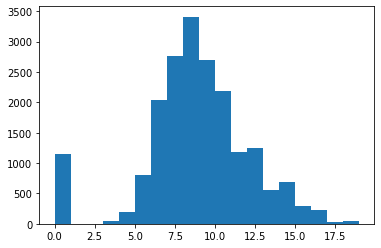

In [4]:
plt.hist(obs_bayes2_j01f28['num_horses'], bins=range(0,20))

In [255]:
def empirical_probs(df):
    pis = get_pools_i(df)

    marked = [0 for i in range(df.shape[0])]
    for jth in range(16):
        res = []
        for i in range(len(pis)):
            sorted_list = sorted([[k,v] for k,v in pis[i].items()], key=lambda x: -x[1])
            if jth < len(sorted_list) and sorted_list[jth][0] == str(number_only(df.iloc[i]['winner'])):
                res.append(1)
                marked[i] = 1
            else:
                res.append(0)
        print(f'{jth+1} winrate: {np.average(res)}, total: {np.sum(res)}')
    print('total untouched:', np.sum([1 for k in marked if k == 0]))
    print('earliest untouched:', np.argmin(marked))

In [256]:
empirical_probs(obs_bayes2_m15m29)

1 winrate: 0.39929401993355484, total: 1923
2 winrate: 0.21324750830564784, total: 1027
3 winrate: 0.13538205980066445, total: 652
4 winrate: 0.09447674418604651, total: 455
5 winrate: 0.0625, total: 301
6 winrate: 0.03820598006644518, total: 184
7 winrate: 0.026578073089700997, total: 128
8 winrate: 0.01079734219269103, total: 52
9 winrate: 0.007682724252491694, total: 37
10 winrate: 0.006229235880398671, total: 30
11 winrate: 0.0020764119601328905, total: 10
12 winrate: 0.0012458471760797341, total: 6
13 winrate: 0.0012458471760797341, total: 6
14 winrate: 0.0006229235880398671, total: 3
15 winrate: 0.00020764119601328904, total: 1
16 winrate: 0.0, total: 0
total untouched: 1
earliest untouched: 3578


Historically, the favorite horse wins about 33% of the time. Empirically, it's 31% for 1 day, so that sounds about right.
1. 0.33
2. 0.28
3. 0.13
4. 0.09
5. 0.08
6. 0.05
7. 0.03 
8. 0.01
9. 0.00

Does my model predict the favorite horse to win 31% of the time?
What about the winrate for the 2nd favorite, historically, and for my model?
etc.

## Returns based on number of horses in a race

* scores: winning probabilities (p)
* pool_size: total money in the pool (omega)
* pools_i: money in the pool for a specific horse (h0)
* s: remaining pool after takeaway (s). estimate this to be something.

Use gradient descent to find the expected return for each horse. Using the same GD, find the optimal bet size for each horse.

expected return `E[r] = b*(s*(pool+b)/(h0+b) - 1)*p + (1-p)*-b`

`dr = dr = -(s*pool*p+2*s*p*b)/(h0+b) + (s*pool*b*p+s*p*(b**2))/((h0+b)**2) + 1`

In [5]:
def extract_dict(row, col_name):
    return json.loads(row.replace("\'", "\""))
def get_scores(df):
    return df['scores'].apply(lambda x: extract_dict(x, 'scores'))
def get_pools_i(df):
    return df['pools_i'].apply(lambda x: extract_dict(x, 'pools_i'))

def get_old_odds(pool, s, h0):
    return (pool*s-h0)/h0

def size_bet_odds(pool, s, p, h0, lr=10, precision=0.001, max_iters=100000):
    b = 0
    iters = 0
    prev_step_size = 1
    
    record = []
    
    while iters < max_iters and prev_step_size > precision:
        dr = -(s*pool*p+2*s*p*b)/(h0+b) + (s*pool*b*p+s*p*(b**2))/((h0+b)**2) + 1 # negative to be a convex function
        prev_b = b
        b = b - lr*dr
        if b < 0:
            break
        prev_step_size = abs(b-prev_b)
        
        if iters % 1000 == 0:
            odds = get_old_odds(pool, s, h0)
            Er = odds*b*p - b*(1-p)
            record.append(b)
        
        iters += 1
    if iters >= max_iters:
        record.append(b)
        print(f'max iters. dr={dr}')
        print(' ', record)
    
    return b, s*(pool+b)/(h0+b)-1
def b_star(omega, omega_i, s, p_i):
    if p_i <= omega_i/(s*omega):
        return 0
    root = np.sqrt((omega_i**2)*(s*p_i-1)**2 - (s*p_i-1)*(s*p_i*omega*omega_i - (omega_i**2)) )
    return max(-omega_i + 2*root/(2*(s*p_i)-1), -omega_i - 2*root/(2*s*p_i-2))

def number_only(n):
    return n if n[-1].isdigit() else n[:-1]

def sim(df, money, E_money, verbose=False, graphs=False):
    if verbose:
            print("=====")
    ps = []
    # for each race j,
    results = []
    returns = []
    bet_times = []
    scores = get_scores(df)
    pools_i = get_pools_i(df)
    
    for j in range(df.shape[0]):
        if money[-1] < 30:
            break
        s = 1 - df['takeout'][j]
        pool = df['pool_size'][j]
        if df['num_horses'][j] > 8 or df['num_horses'][j] < 6:
            money.append(money[-1])
            E_money.append(E_money[-1])
            continue
        
        positive_horse_pEr_list = []
        missing_category = False
        for k,v in scores[j].items():
            # get p = v
            # remove the letter, if it exists. get h0 = pools_i[the remaining number]
            
            p = float(v)
            ps.append(p)
            pool_category = number_only(k)
            
            if pool_category not in pools_i[j].keys():
                missing_category = True
                break
    
            h0 = pools_i[j][pool_category]
#             b, odds = size_bet_odds(pool, s, p, h0)
            b = b_star(pool, h0, s, p)
            b = min(b, money[-1])
            odds = s*(pool+b)/(h0+b) - 1
            Er = (odds)*b*p - b*(1-p)
            if b >= 2:
                pEr = Er/b # expected percent return
#                 if pEr > (1/s - 1) + 0.1:
                if odds > (1/p) - 1:
                    positive_horse_pEr_list.append([pEr, Er, b, odds, p, k, df['num_horses'][j], money[-1], j])
        if missing_category:
            money.append(money[-1])
            E_money.append(E_money[-1])
            continue
        
        sorted_list = sorted(positive_horse_pEr_list, key=lambda x: -x[1]) # 0 or 1
        if sorted_list:
            pEr, Er, b, odds, p, choice, num_horses, cur_money, ji = sorted_list[0]
            
            winner = number_only(str(df['winner'][j]))
            choice = number_only(choice)
            
            E_money.append(E_money[-1] + Er)
            bet_times.append(df["datetime"][j])
            
            stats = f'b: {b}, odds: {odds}, p_hat: {p}, Er: {Er}, pEr: {pEr}, s: {s}, choice: {choice}, num_horses = {num_horses}, cur_money: {cur_money}.'
            if choice == winner:
                results.append(1)
                returns.append(b*odds)
                if verbose:
                    print(f'race {j}. datetime: {df["datetime"][j]}')
                    print(f'  Won ({b*odds}). {stats}')
                money.append(money[-1] + b*odds)
            else:
                results.append(0)
                returns.append(-b)
                if verbose:
                    pass
                    print(f'race {j}. datetime: {df["datetime"][j]}')
                    print(f'  Lost ({b}). {stats}')
                money.append(money[-1] - b)
        else:
            money.append(money[-1])
            E_money.append(E_money[-1])
    print(f'winrate: {np.average(results)}. num bets: {len(results)}')  
    if graphs:
        plt.hist([bt.hour for bt in bet_times])
        plt.title('bet times')
        plt.show()
        plt.hist(returns)
        plt.title('returns')
        plt.show()
        plt.hist(ps)
        plt.title('p\'s')
        plt.show()
        
def sim_plots(dfs, labels):
    plt.figure(figsize=(5, 3), dpi=80)
    for df, label in zip(dfs, labels):
#         df = df.sort_values('datetime').reset_index(drop=True)
        df = df.sort_values('datetime')
        df = df.reset_index(drop=True)

        money = [100000]
        E_money = [100000]
        sim(df, money, E_money, verbose=True, graphs=False)
        plt.plot(df['datetime'][:len(money)-1], money[1:], label=label)
        plt.plot(df['datetime'][:len(E_money)-1], E_money[1:], label=f'E[{label}]')
    plt.grid()
    plt.xlabel('bets')
    plt.ylabel('cash')
    plt.legend()
    plt.show()

=====
race 0. datetime: 2022-03-15 16:01:00
  Lost (31.647072728561454). b: 31.647072728561454, odds: 6.9244499959725605, p_hat: 0.1400233372228704, Er: 3.4687702618318212, pEr: 0.10960793409183969, s: 0.8095634095634097, choice: 5, num_horses = 8, cur_money: 100000.
race 3. datetime: 2022-03-15 16:50:00
  Lost (116.95978834281914). b: 116.95978834281914, odds: 11.12012814988848, p_hat: 0.101516919486581, Er: 26.947309918085793, pEr: 0.23039807355927255, s: 0.8080489288578848, choice: 5, num_horses = 8, cur_money: 99968.35292727144.
race 4. datetime: 2022-03-15 16:50:00
  Lost (26.317998759889974). b: 26.317998759889974, odds: 26.966627535291728, p_hat: 0.0408401400233372, Er: 3.741392614350307, pEr: 0.1421609845218318, s: 0.8105299618981642, choice: 7, num_horses = 8, cur_money: 99851.39313892862.
race 5. datetime: 2022-03-15 16:55:00
  Lost (125.19800768377002). b: 125.19800768377002, odds: 10.47876179748778, p_hat: 0.101516919486581, Er: 20.693795550556032, pEr: 0.1652885372012087, 

race 3103. datetime: 2022-03-25 09:53:00
  Lost (4.3724895158808295). b: 4.3724895158808295, odds: 18.370830366256097, p_hat: 0.0518731988472622, Er: 0.021105724541340187, pEr: 0.0048269354253874025, s: 0.8481071451706939, choice: 6, num_horses = 7, cur_money: 87609.42742258776.
race 3108. datetime: 2022-03-25 10:05:00
  Lost (70.81401266157985). b: 70.81401266157985, odds: 11.264068024434515, p_hat: 0.101516919486581, Er: 17.35017000789037, pEr: 0.24501040621447095, s: 0.818806795732912, choice: 2, num_horses = 8, cur_money: 87605.05493307188.
race 3151. datetime: 2022-03-25 11:30:00
  Lost (34.24282326236039). b: 34.24282326236039, odds: 10.177927047102793, p_hat: 0.101516919486581, Er: 4.614176606104454, pEr: 0.1347487200676103, s: 0.8188108431930508, choice: 4, num_horses = 8, cur_money: 87534.2409204103.
race 3258. datetime: 2022-03-25 15:22:00
  Lost (16.759501547772857). b: 16.759501547772857, odds: 9.376591212603675, p_hat: 0.101516919486581, Er: 0.8949502544169317, pEr: 0.0533

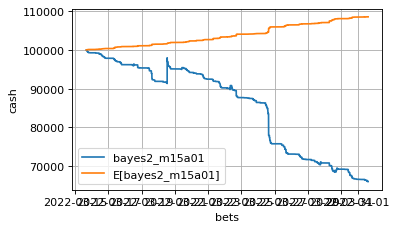

In [6]:
sim_plots(all_obs, all_labels)

## Old way of simulating

In [524]:
def extract_dict(row, col_name):
    return json.loads(row.replace("\'", "\""))
def get_scores(df):
    return df['scores'].apply(lambda x: extract_dict(x, 'scores'))
def get_pools_i(df):
    return df['pools_i'].apply(lambda x: extract_dict(x, 'pools_i'))

def get_old_odds(pool, s, h0):
    return (pool*s-h0)/h0

def size_bet_odds(pool, s, p, h0, lr=10, precision=0.1, max_iters=10000):
    b = 0
    iters = 0
    prev_step_size = 1
    
    while iters < max_iters and prev_step_size > precision:
        dr = -(s*pool*p+2*s*p*b)/(h0+b) + (s*pool*b*p+s*p*(b**2))/((h0+b)**2) + p + 1
        prev_b = b
        b = b - lr*dr
        prev_step_size = abs(b-prev_b)
        iters += 1
    if iters >= max_iters:
#         print('max iters')
        pass
    return b, s*(pool+b)/(h0+b)-1

def number_only(n):
    return n if n[-1].isdigit() else n[:-1]

def sim(df, money, verbose=False, graphs=False):
    ps = []
    # for each race j,
    results = []
    returns = []
    scores = get_scores(df)
    pools_i = get_pools_i(df)
    
    odds_rank_winners = pd.read_csv('odds_ranks.csv')
    odds_probs = (odds_rank_winners['odds_rank'].value_counts() / odds_rank_winners.shape[0]).to_list()
    
    for j in range(df.shape[0]):
        s = 1 - df['takeout'][j]
        pool = df['pool_size'][j]
        
        # for each horse in the race,
        # get scores and pools_i. may need to combine the keys in scores to match pools_i.
        # calculate the expected return and optimal bet size.
        
        if verbose:
            print(f'race {j}:')
        
        sorted_odds = sorted([[k, get_old_odds(pool,s,v)] for k,v in pools_i[j].items() if v!=0], key=lambda x: x[1])
        for i in range(len(sorted_odds)):
            sorted_odds[i].append(odds_probs[i] if i < len(odds_probs) else 0) # [k, odds, p]
        key_oddsp = { s[0]: s[1:] for s in sorted(sorted_odds, key=lambda x: int(number_only(x[0]))) }
        
        positive_horse_pEr_list = []
        for k,v in scores[j].items():
            # get p = v
            # remove the letter, if it exists. get h0 = pools_i[the remaining number]
            
#             p = v
            p = key_oddsp.get(number_only(k),[0,0])[1]
    
            ps.append(p)
            pool_category = number_only(k)
            if pool_category not in pools_i[j].keys():
                continue
    
            h0 = pools_i[j][pool_category]
            b, odds = size_bet_odds(pool, s, p, h0)
            b = min(max(b, 0), money[-1]/10)
            Er = (odds+1)*b*p - b*(1-p)
            if b >= 2:
                pEr = Er/b # expected percent return
                if pEr > (1/s - 1)+0.1:
                    positive_horse_pEr_list.append([pEr, Er, b, odds, p, k])
        
        sorted_list = sorted(positive_horse_pEr_list, key=lambda x: -x[1]) # 0 or 1
        if sorted_list:
            pEr, Er, b, odds, p, choice = sorted_list[0]
            
            winner = number_only(str(df['winner'][j]))
            choice = number_only(choice)
            
            if choice == winner:
                results.append(1)
                returns.append(b*odds)
                if verbose:
                    print(f'  Won {b*odds}. b: {b}, odds: {odds}, p_hat: {p}, Er: {Er}.')
                money.append(money[-1] + b*odds)
            else:
                results.append(0)
                returns.append(-b)
                if verbose:
                    print(f'  Lost {b}. b: {b}, odds: {odds}, p_hat: {p}, Er: {Er}.')
                money.append(money[-1] - b)
        else:
            money.append(money[-1])
    print(f'winrate: {np.average(results)}')  
    if graphs:
        plt.hist(returns)
        plt.title('returns')
        plt.show()
        plt.hist(ps)
        plt.title('p\'s')
        plt.show()
        
def sim_plots(dfs, labels):
    for df, label in zip(dfs, labels):
        df = df.sort_values('datetime').reset_index(drop=True)
        money = [1000]
        sim(df, money, verbose=False, graphs=False)
        plt.plot(df['datetime'], money[1:], label=label)
    plt.grid()
    plt.xlabel('bets')
    plt.ylabel('cash')
    plt.legend()
    plt.show()

winrate: 0.20833333333333334
winrate: 0.14685314685314685


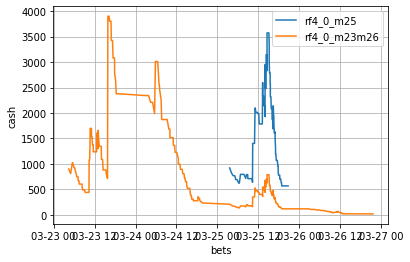

In [526]:
sim_plots(all_obs, all_labels)

winrate: 0.20833333333333334


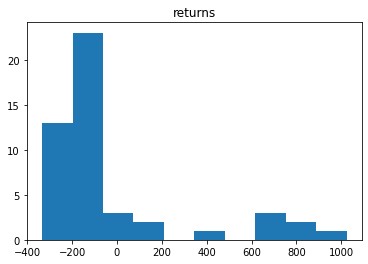

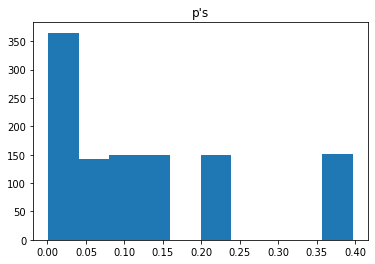

In [522]:
obs_rf4_0_m25 = obs_rf4_0_m25.sort_values('datetime').reset_index(drop=True)
money1=[1000]
sim(obs_rf4_0_m25, money1, verbose=False, graphs=True)

winrate: 0.14685314685314685


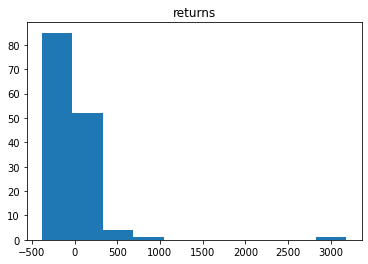

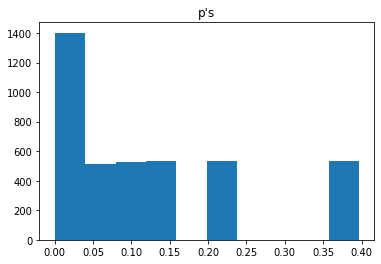

In [520]:
obs_rf4_0_m23m26 = obs_rf4_0_m23m26.sort_values('datetime').reset_index(drop=True)
money2=[1000]
sim(obs_rf4_0_m23m26, money2, verbose=False, graphs=True)

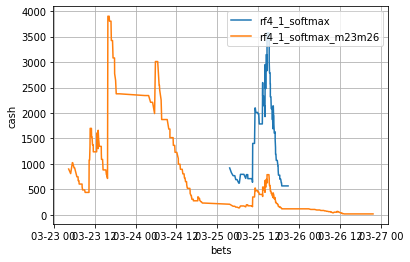

In [523]:
plt.plot(obs_rf4_0_m25['datetime'], money1[1:], label='rf4_1_softmax')
plt.plot(obs_rf4_0_m23m26['datetime'], money2[1:], label='rf4_1_softmax_m23m26')
# plt.plot(money3, label='rf4_1_no_softmax')
plt.grid()
plt.xlabel('bets')
plt.ylabel('cash')
plt.legend()
plt.show()

# Estimate takeouts

In [440]:
et = pd.read_csv("estimates.csv")


In [441]:
et[et['park'] == 'SE - Boden']

,park,takeout_hat
429,SE - Boden,0.153120
432,SE - Boden,0.094906
450,SE - Boden,0.151951
527,SE - Boden,0.151804
538,SE - Boden,0.151080
628,SE - Boden,0.152391
635,SE - Boden,0.151340
639,SE - Boden,0.151534
650,SE - Boden,0.151190
651,SE - Boden,0.153515


In [442]:
df = pd.concat([et.groupby('park').count(), et.groupby('park').median()], axis=1)
df.columns = ['count', 'takeout']
df = df.sort_values('takeout')

In [443]:
df.to_csv('takeout_estimates.csv')

In [435]:
df.shape

(208, 2)

In [436]:
df[:50]

,count,takeout
park,,
NO - Momarken,12,0.151066
SE - Farjestad,8,0.151189
SE - Ostersund,10,0.151214
SE - Bollnas,8,0.151263
SE - Romme,11,0.151338
SE - Aby,28,0.151513
SE - Boden,11,0.151534
SE - Mantorp,5,0.151603
SE - Umaker,7,0.151827


In [437]:
df[-50:]

,count,takeout
park,,
GB - Newcastle,24,0.200503
GB - Kempton Park,20,0.200707
DK - Skive,12,0.200889
NO - Bergen,7,0.201157
NO - Forus,8,0.201206
GB - Wincanton,8,0.201270
NO - Jarlsberg,25,0.201309
GB - Kelso,6,0.201323
DK - Odense,10,0.201547


# Estimate odds rank winrates

In [57]:
odds_rank_winners = pd.read_csv('odds_ranks_2.csv')

In [88]:
result

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


In [101]:
low, high = 1, 20

result = pd.DataFrame(columns=[str(i) for i in range(low, high)])
for i in range(low, high):
    dist = odds_rank_winners[odds_rank_winners['num_horses']==i]
    probs = (dist.value_counts()/dist.shape[0]).to_list()
    probs = probs + [0]*(high-low - len(probs))
    result.loc[0 if pd.isnull(result.index.max()) else result.index.max() + 1] = probs
result

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.611111,0.388889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.465517,0.189655,0.189655,0.155172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.460674,0.275281,0.140449,0.073034,0.050562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.461024,0.229399,0.142539,0.089087,0.051225,0.026726,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.442363,0.237752,0.121037,0.092219,0.051873,0.033141,0.021614,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.417736,0.212369,0.140023,0.101517,0.064177,0.040840,0.022170,0.001167,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.371324,0.196691,0.132353,0.119485,0.062500,0.044118,0.042279,0.018382,0.012868,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.330667,0.202667,0.154667,0.090667,0.074667,0.053333,0.034667,0.026667,0.021333,0.010667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:

winrates = odds_rank_winners['odds_rank'].value_counts() / odds_rank_winners.shape[0]

In [55]:
winrates = odds_rank_winners['odds_rank'].value_counts() / odds_rank_winners.shape[0]

In [56]:
winrates

1     0.397765
2     0.210058
3     0.133096
4     0.097790
5     0.064770
6     0.039116
7     0.026416
8     0.010668
9     0.007874
10    0.005842
11    0.002540
13    0.001524
12    0.001270
14    0.000762
15    0.000254
19    0.000254
Name: odds_rank, dtype: float64

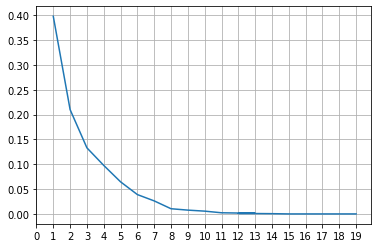

In [477]:
plt.plot(winrates)
plt.xticks(range(20))
plt.grid()
plt.show()

In [97]:
odds_probs = pd.read_csv('odds_probs.csv')

In [98]:
odds_probs

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.611111,0.388889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.465517,0.189655,0.189655,0.155172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.460674,0.275281,0.140449,0.073034,0.050562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.461024,0.229399,0.142539,0.089087,0.051225,0.026726,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.442363,0.237752,0.121037,0.092219,0.051873,0.033141,0.021614,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.417736,0.212369,0.140023,0.101517,0.064177,0.040840,0.022170,0.001167,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.371324,0.196691,0.132353,0.119485,0.062500,0.044118,0.042279,0.018382,0.012868,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.330667,0.202667,0.154667,0.090667,0.074667,0.053333,0.034667,0.026667,0.021333,0.010667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Return graphs

In [33]:
def b_star(omega, omega_i, s, p_i):
    if p_i <= omega_i/(s*omega):
        return 0
    root = np.sqrt((omega_i**2)*(s*p_i-1)**2 - (s*p_i-1)*(s*p_i*omega*omega_i - (omega_i**2)) )
    pair = [-omega_i + 2*root/(2*(s*p_i)-1),-omega_i - 2*root/(2*s*p_i-2)]
    return min([i for i in pair if i > 0])

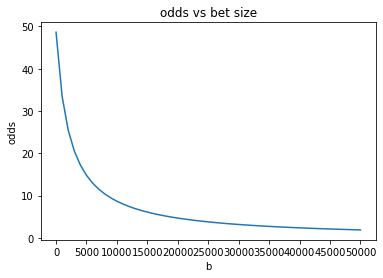

In [43]:
omega = 702+14399+1065+2215+37447+36307+2374+7539+4545+1134+4367+9776+1013+562+13533
s = 0.802631
p_i = 0.1551724
omega_i = 2215

plt.plot([b for b in np.arange(0, 50001, 1000)], [s*(omega+b)/(omega_i+b) - 1 for b in np.arange(0, 50001, 1000)])
plt.title('odds vs bet size')
plt.xticks(np.arange(0, 50001, 5000))
plt.xlabel('b')
plt.ylabel('odds')
plt.show()

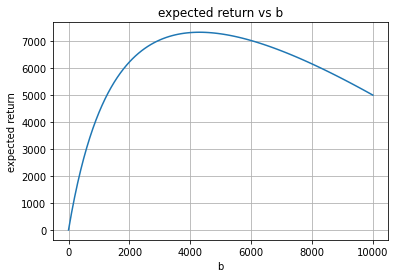

In [47]:
plt.plot(np.arange(0, 10001, 100),[s*p_i*(omega*b + b**2)/(omega_i+b) - b for b in np.arange(0, 10001, 100)])
plt.title('expected return vs b')
plt.xlabel('b')
plt.ylabel('expected return')
plt.grid()
plt.show()

In [45]:
b_star(omega, omega_i, s, p_i)

4301.595774086871

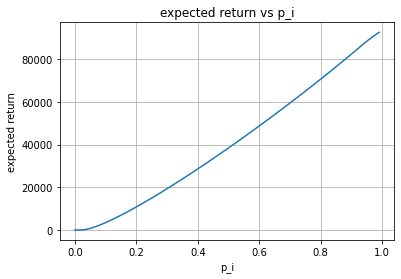

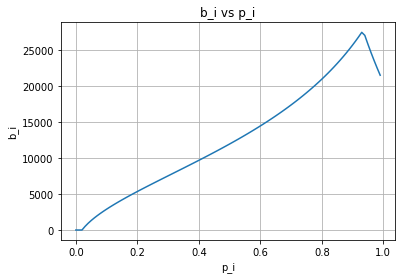

In [38]:
points = []
bs = []
for p in np.arange(0, 1, 0.01):
    b = b_star(omega, omega_i, s, p)
    bs.append(b)
    points.append(s*p*(omega*b + b**2)/(omega_i+b) - b)

plt.plot(np.arange(0, 1, 0.01), points)
plt.title('expected return vs p_i')
plt.xlabel('p_i')
plt.ylabel('expected return')
plt.grid()
plt.show()
plt.plot(np.arange(0, 1, 0.01), bs)
plt.title('b_i vs p_i')
plt.xlabel('p_i')
plt.ylabel('b_i')
plt.grid()
plt.show()

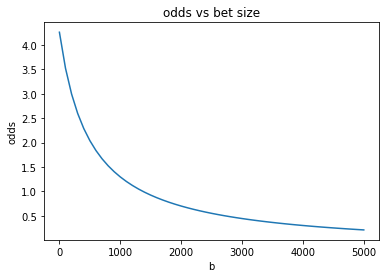

In [39]:
omega = 3314
s = 0.8
p_i = 0.212
omega_i = 504

plt.plot([b for b in np.arange(0, 5001, 100)], [s*(omega+b)/(omega_i+b) - 1 for b in np.arange(0, 5001, 100)])
plt.title('odds vs bet size')
plt.xticks(np.arange(0, 5001, 1000))
plt.xlabel('b')
plt.ylabel('odds')
plt.show()

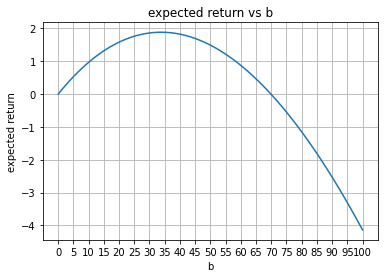

In [40]:
plt.plot(np.arange(0, 101, 1),[s*p_i*(omega*b + b**2)/(omega_i+b) - b for b in np.arange(0, 101, 1)])
plt.title('expected return vs b')
plt.xlabel('b')
plt.ylabel('expected return')
plt.xticks(np.arange(0, 101, 5))
plt.grid()
plt.show()

In [41]:
b_star(omega, omega_i, s, p_i)

33.820908369848325

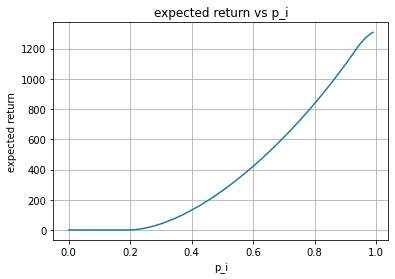

In [42]:
points = []
for p in np.arange(0, 1, 0.01):
    b = b_star(omega, omega_i, s, p)
    points.append(s*p*(omega*b + b**2)/(omega_i+b) - b)

plt.plot(np.arange(0, 1, 0.01), points)
plt.title('expected return vs p_i')
plt.xlabel('p_i')
plt.ylabel('expected return')
plt.grid()
plt.show()

## pool_size distribution

pool_size is roughly lognormal.

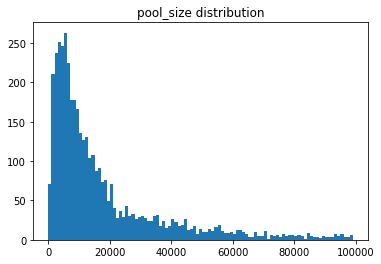

In [21]:
plt.hist(obs_bayes2_m15m29['pool_size'], bins = np.arange(0,100000,1000))
plt.title('pool_size distribution')
plt.show()

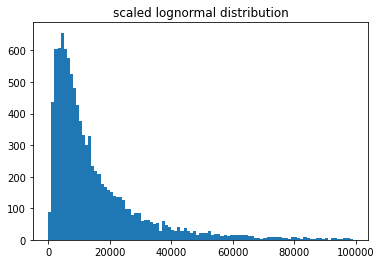

In [22]:
plt.hist(10000*np.exp(np.random.normal(size=10000)), bins=np.arange(0,100000,1000))
plt.title('scaled lognormal distribution')
plt.show()

## Odds threshold for a bet

In [2]:
import numpy as np

In [7]:
depth = 10000
odds_i = 9
p_i = 0.1

np.sum([(odds_i-j+1)*p_i*(1-p_i)**j for j in range(1,depth)])

-1.948155666204153e-15

In [9]:
# odds threshold
1/p_i - 1

9.0